# Датасет для детекции людей

## Imports

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from pathlib import Path
import random
import shutil

from pydantic import BaseModel
import datumaro as dm

from ppe_modelling.utils import system_info_banner
from ppe_modelling.logger import logger

## System Info

In [67]:
logger.info(system_info_banner())

[ppe-modelling] 09.04.2025 22:56:21 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [87]:
class PersonDetectionDatasetSettings(BaseModel):
    coco_persons_dir: Path = '../data/coco_persons'
    construction_ds_dir: Path = '../data/construction-site-safety-image-dataset-roboflow-coco-apr-6'
    out_path: Path = '../data/person_coco_instances'

settings = PersonDetectionDatasetSettings()

## Import datasets

In [69]:
# coco_persons
ds_coco_persons = dm.Dataset.import_from(settings.coco_persons_dir, "coco_instances")
ds_coco_persons

Dataset
	size=5243
	source_path=../data/coco_persons
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.polygon: 4>, <AnnotationType.bbox: 6>}
	annotated_items_count=5243
	annotations_count=41525
subsets
	test: # of items=520, # of annotated items=520, # of annotations=4061
	train: # of items=3721, # of annotated items=3721, # of annotations=29502
	valid: # of items=1002, # of annotated items=1002, # of annotations=7962
infos
	categories
	label: ['People', 'person']

In [70]:
# construction
ds_construction = dm.Dataset.import_from(settings.construction_ds_dir, "coco_instances")
ds_construction

Dataset
	size=2801
	source_path=../data/construction-site-safety-image-dataset-roboflow-coco-apr-6
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.bbox: 6>}
	annotated_items_count=2777
	annotations_count=38352
subsets
	test: # of items=82, # of annotated items=74, # of annotations=760
	train: # of items=2605, # of annotated items=2599, # of annotations=36895
	val: # of items=114, # of annotated items=104, # of annotations=697
infos
	categories
	label: ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

## Inspect

/tmp/ipykernel_754178/3253123604.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


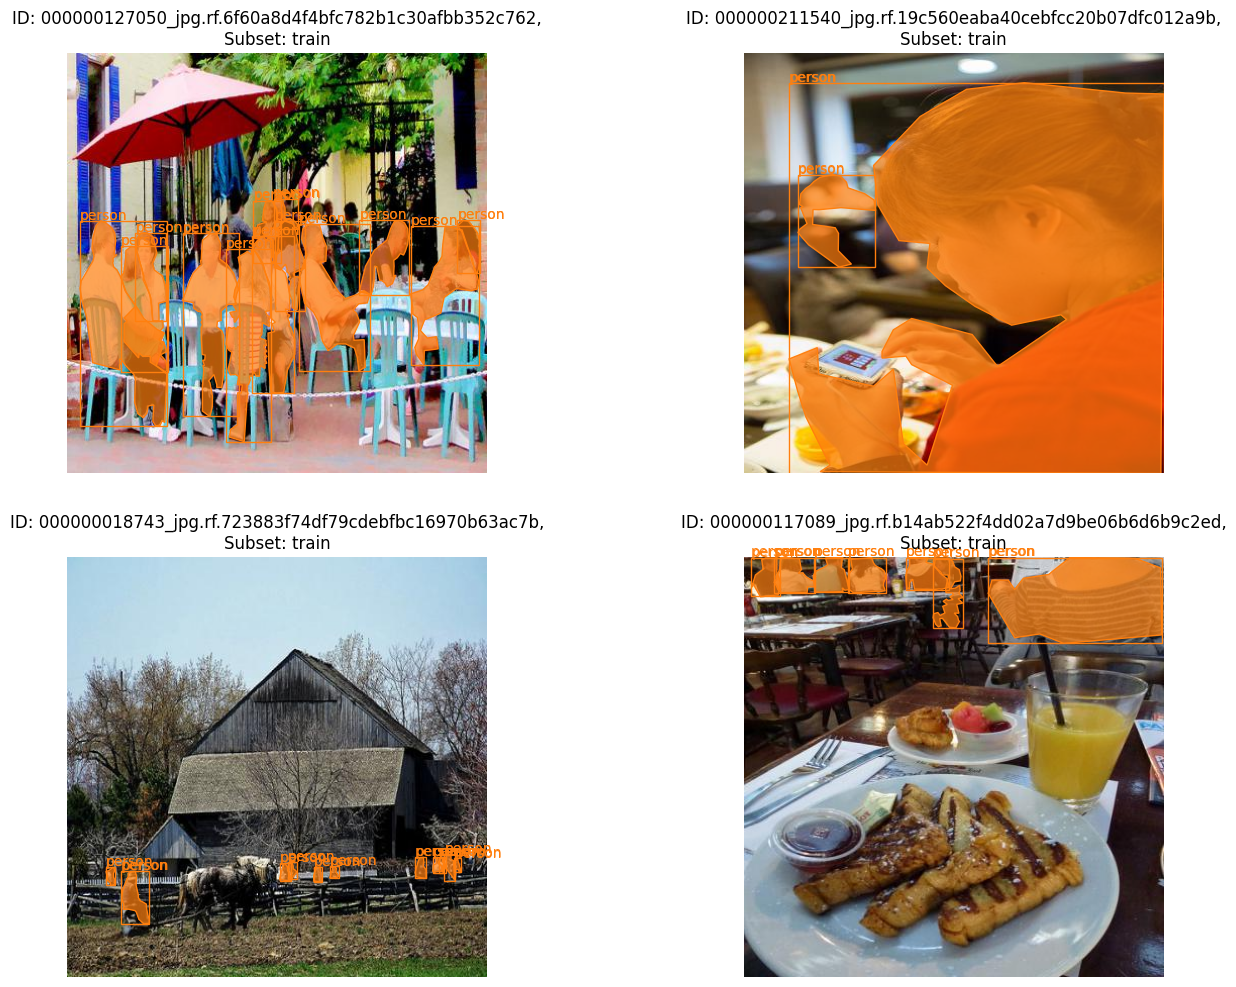

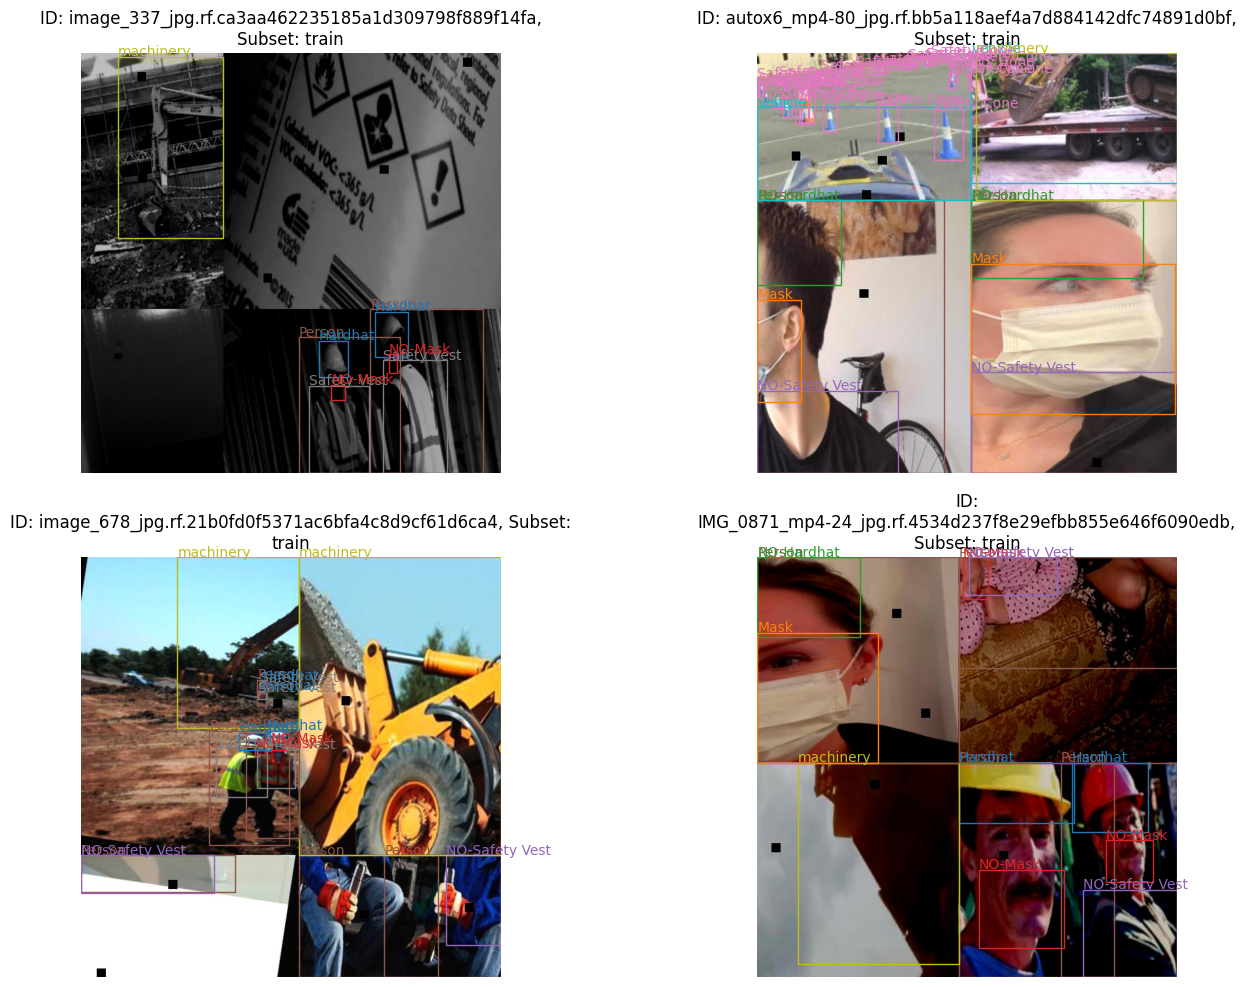

In [71]:
def get_ids(dataset: dm.Dataset, subset: str):
    ids = []
    for item in dataset:
        if item.subset == subset:
            ids += [item.id]

    return ids

def inspect_ds(dataset: dm.Dataset, subset: str = "train"):
    subset = 'train'
    ids = get_ids(dataset, subset)
    visualizer = dm.Visualizer(dataset, figsize=(16, 12), alpha=0.7)
    fig = visualizer.vis_gallery(random.sample(ids, 4), subset, grid_size=(None, None))
    fig.show()

inspect_ds(ds_coco_persons)
inspect_ds(ds_construction)

## Build dataset

In [80]:
def prepare_coco_persons(ds: dm.Dataset) -> dm.Dataset:
    # Map classes
    mapping = {'person': 'person', 'People': 'person'}
    ds = ds.clone()
    ds = ds.transform('remap_labels', mapping=mapping, default='delete')
    ds = ds.transform('reindex')
    ds = ds.transform('map_subsets', mapping={"valid": "val"})
    return ds

def prepare_construction(ds: dm.Dataset) -> dm.Dataset:
    mapping = {'Person': 'person'}
    ds = ds.clone()
    ds = ds.transform('remap_labels', mapping=mapping, default='delete')
    ds = ds.transform('reindex')
    return ds

prepared_ds_coco_persons = prepare_coco_persons(ds_coco_persons)
prepared_ds_construction = prepare_construction(ds_construction)

In [81]:
prepared_ds_construction

Dataset
	size=2801
	source_path=../data/construction-site-safety-image-dataset-roboflow-coco-apr-6
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.bbox: 6>}
	annotated_items_count=2669
	annotations_count=9872
subsets
	test: # of items=82, # of annotated items=59, # of annotations=174
	train: # of items=2605, # of annotated items=2526, # of annotations=9532
	val: # of items=114, # of annotated items=84, # of annotations=166
infos
	categories
	label: ['person']

In [82]:
prepared_ds_coco_persons

Dataset
	size=5243
	source_path=../data/coco_persons
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.polygon: 4>, <AnnotationType.bbox: 6>}
	annotated_items_count=5243
	annotations_count=41525
subsets
	test: # of items=520, # of annotated items=520, # of annotations=4061
	train: # of items=3721, # of annotated items=3721, # of annotations=29502
	val: # of items=1002, # of annotated items=1002, # of annotations=7962
infos
	categories
	label: ['person']

In [83]:
ds = dm.HLOps.merge(prepared_ds_coco_persons, prepared_ds_construction, merge_policy='union')
ds

Dataset
	size=8044
	source_path=None
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.polygon: 4>, <AnnotationType.bbox: 6>}
	annotated_items_count=7912
	annotations_count=51397
subsets
	test: # of items=602, # of annotated items=579, # of annotations=4235
	train: # of items=6326, # of annotated items=6247, # of annotations=39034
	val: # of items=1116, # of annotated items=1086, # of annotations=8128
infos
	categories
	label: ['person']

## Export DS

In [88]:
def export_ds_to_coco_instances(ds: dm.Dataset, path: Path | str):
    path = Path(path)
    format = "coco_instances"
    if path.exists():
        shutil.rmtree(path)
    ds.export(path, format, save_media=True, reindex=True)
    logger.info(f"Saved '{format}' dataset to {str(path)}")

export_ds_to_coco_instances(ds, settings.out_path)

[ppe-modelling] 09.04.2025 23:00:27 Saved 'coco_instances' dataset to ../data/person_coco_instances
